In [21]:
%matplotlib notebook
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
from tqdm import tqdm
from torch.utils.data.sampler import SubsetRandomSampler
from data_generator_boneage import BoneAgeDataset
from models import BreastPathQModel
from uce import uceloss
from calibration_plots import plot_uncert, plot_frequency
from utils import nll_criterion_gaussian
from glob import glob
from test import AuxModel, train_aux
%matplotlib notebook

In [22]:
base_model = 'densenet201'

In [23]:
assert base_model in ['densenet201']
device = torch.device("cuda:0")
resize_to = (256, 256)

In [24]:
batch_size = 16

data_set = BoneAgeDataset(data_dir='/media/fastdata/laves/rsna-bone-age/', augment=False, resize_to=resize_to)
assert len(data_set) > 0

calib_indices = torch.load('./boneage_valid_indices.pth')
test_indices = torch.load('./boneage_test_indices.pth')

print(calib_indices.shape)
print(test_indices.shape)

calib_loader = torch.utils.data.DataLoader(data_set, batch_size=batch_size,
                                           sampler=SubsetRandomSampler(calib_indices))
test_loader = torch.utils.data.DataLoader(data_set, batch_size=batch_size,
                                          sampler=SubsetRandomSampler(test_indices))

torch.Size([2000])
torch.Size([4000])


In [25]:
ensembles = []

for i in range(5):
    model = BreastPathQModel(base_model, in_channels=1, out_channels=1).to(device)

    checkpoint_path = glob(f"/media/fastdata/laves/regression_snapshots/{base_model}_gaussian_boneage_ensemble_{i}.pth.tar")[0]

    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['state_dict'])
    print("Loading previous weights at epoch " + str(checkpoint['epoch']))
    model.eval()
    ensembles.append(model)

Loading previous weights at epoch 478
Loading previous weights at epoch 366
Loading previous weights at epoch 499
Loading previous weights at epoch 499
Loading previous weights at epoch 499


In [26]:
mus_test = []
vars_test = []
logvars_test = []
targets_test = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tqdm(test_loader)):
        data, target = data.to(device), target.to(device)

        mus = []
        logvars = []
        for net in ensembles:
            mu, logvar, _ = net(data, dropout=False, mc_dropout=False)
            mus.append(mu)
            logvars.append(logvar)

        mus = torch.stack(mus)
        var = mus.var(dim=0)
        mus = mus.mean(dim=0)
        logvars = torch.stack(logvars).mean(dim=0)

        mus_test.append(mu.detach())
        vars_test.append(var.detach())
        logvars_test.append(logvar.detach())
        targets_test.append(target.detach())

mu_test = torch.cat(mus_test, dim=0).clamp(0, 1)
var_test = torch.cat(vars_test, dim=0)
logvar_test = torch.cat(logvars_test, dim=0)
target_test = torch.cat(targets_test, dim=0)

print("l1 =", torch.nn.functional.l1_loss(mu_test, target_test).item())


100%|██████████| 250/250 [02:29<00:00,  1.68it/s]

l1 = 0.052034247666597366


In [27]:
err_test = torch.pow(target_test-mu_test, 2).sqrt()

uncert_aleatoric_test = logvar_test.exp()
uncert_epistemic_test = var_test

uncertainty = 'total'

if uncertainty == 'aleatoric':
    uncert_test = uncert_aleatoric_test.sqrt().clamp(0, 1)
elif uncertainty == 'epistemic':
    uncert_test = uncert_epistemic_test.sqrt().clamp(0, 1)
else:
    uncert_test = (uncert_aleatoric_test + uncert_epistemic_test).sqrt().clamp(0, 1)  # total

In [28]:
print(err_test.mean())
print(uncert_test.mean())
print(uncert_aleatoric_test.mean())
print(uncert_epistemic_test.mean())

tensor(0.0520, device='cuda:0')
tensor(0.0707, device='cuda:0')
tensor(0.0047, device='cuda:0')
tensor(0.0005, device='cuda:0')


In [29]:
print(nll_criterion_gaussian(mu_test, uncert_test.pow(2).log(), target_test).item())

-4.392894744873047


In [30]:
print(torch.nn.functional.mse_loss(uncert_test**2, err_test**2, reduction='sum').item())

0.26705870032310486


<IPython.core.display.Javascript object>


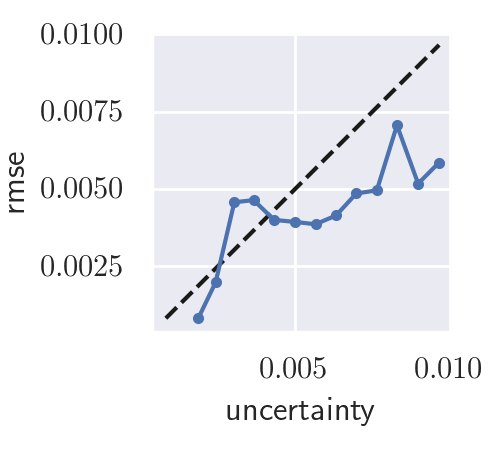

0.0009166249074041843


In [62]:
n_bins = 15
uce_uncal, _, _, _ = uceloss(err_test**2, uncert_test**2, n_bins=n_bins)
_, err_uncal, sigma_uncal, _ = uceloss(err_test**2, uncert_test**2, n_bins=n_bins, range=[0, 0.01])
plot_uncert(err_uncal.cpu(), sigma_uncal.cpu())
print(uce_uncal.item())

# Rejection of unreliable predictions

In [63]:
import seaborn as sns

sns.set()
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.size'] = 8
matplotlib.rcParams['text.latex.preamble'] = [
    r'\usepackage{bm}']

In [109]:
e_s_list = []
u_s_list = []
t_s_list = []
num_rejected_s = []
uncert_s = uncert_test**2
err = (err_test**2)

for thresh in np.linspace(uncert_s.max().item(), uncert_s.min().item(), 100)[:-1]:
    e = err[torch.where(uncert_s < thresh)]
    u = uncert_s[torch.where(uncert_s < thresh)]

    t_s_list.append(thresh)
    e_s_list.append(e.mean().item())
    u_s_list.append(u.mean().item())
    num_rejected_s.append((err_test.shape[0]-e.shape[0])/err_test.shape[0])

t_s_list = np.array(t_s_list)
e_s_list = np.array(e_s_list)
u_s_list = np.array(u_s_list)
num_rejected_s = np.array(num_rejected_s)

In [119]:
fig, ax = plt.subplots(figsize=(3.0, 2.0))

ax.plot([0.0019, e_s_list.max()], [0.0019, e_s_list.max()], 'k--')
ax.plot(t_s_list, e_s_list)
ax.fill_between(t_s_list, e_s_list-num_rejected_s/1000, e_s_list+num_rejected_s/1000, alpha=0.5)
ax.set_xlim(
    #ax[0].get_xlim()[1],
    0.008,
    0.0015)
ax.set_xlabel(r'uncertainty threshold $ \Sigma^2_{\mathsf{max}} $')
ax.set_ylabel(r'MSE')
ax.set_title(r'5-ensemble')

fig.tight_layout()
fig.show()
fig.savefig(f"rejection_ensemble_{base_model}.pdf", bbox_inches='tight', pad_inches=0.01)

<IPython.core.display.Javascript object>

# OOD detection

In [37]:
mus_ood = []
uncerts_ood = []
errs_ood = []
repetitions = 1

for i in range(repetitions):
    with torch.no_grad():
        for s in [0.0, 0.1, 0.2]:
            mu_ood = []
            uncert_ood = []
            err_ood = []
            for batch_idx, (data, target) in enumerate(tqdm(test_loader)):
                    data, target = data.to(device), target.to(device)
                    img = data + torch.randn_like(data)*s + s
                    mu, logvar, var_bayesian = model(img, dropout=True, mc_dropout=True)

                    err = torch.pow(target-mu, 2)#.sqrt()
                    uncert_aleatoric_test = logvar.exp()
                    uncert_epistemic_test = var_bayesian

                    mu_ood.append(mu.cpu().squeeze().numpy())
                    uncert = (uncert_aleatoric_test + uncert_epistemic_test).clamp(0, 1)
                    uncert_ood.append(uncert.cpu().squeeze().numpy())
                    err_ood.append(err.cpu().squeeze().numpy())
    
            mus_ood.append(mu_ood)
            uncerts_ood.append(uncert_ood)
            errs_ood.append(err_ood)


100%|██████████| 250/250 [06:05<00:00,  1.46s/it]

 24%|██▍       | 60/250 [01:27<04:41,  1.48s/it]


100%|██████████| 250/250 [06:07<00:00,  1.47s/it]

 48%|████▊     | 120/250 [02:56<03:13,  1.49s/it]


100%|██████████| 250/250 [06:09<00:00,  1.48s/it]


In [46]:
mus_ood_np = np.array(mus_ood).reshape(3,-1)
uncerts_ood_np = np.array(uncerts_ood).reshape(3,-1)
errs_ood_np = np.array(errs_ood).reshape(3,-1)

<IPython.core.display.Javascript object>


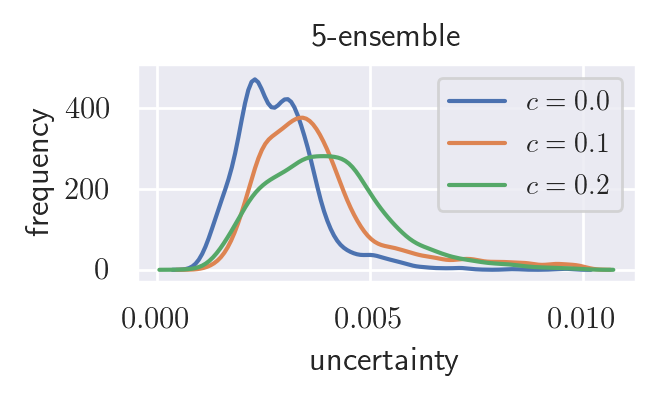

In [108]:
fig, ax = plt.subplots(figsize=(3.3, 2.0))

labels = [r'$c=0.0$', r'$c=0.1$', r'$c=0.2$']

for i in range(3):
    data = uncerts_ood_np[i][np.where(uncerts_ood_np[i] < 0.01)]
    sns.distplot(data, hist_kws={'stacked': True}, kde=True, hist=False, norm_hist=True, label=labels[i], ax=ax)

ax.legend(prop={'size': 10})
ax.set_ylim([-30, 510])
ax.set_xticks([0, 0.005, 0.01])
ax.set_xlabel(r'uncertainty')
ax.set_ylabel(f'frequency')
ax.set_title(f'5-ensemble')
fig.tight_layout()
fig.show()
fig.savefig(f"ood_boneage_ensemble_{base_model}.pdf", bbox_inches='tight', pad_inches=0.01)